In [1]:
#CR_SPACFAR

In [2]:
import numpy as np

def cauchyraylfit(data):
    """
    Parameter estimate for Cauchy-Rayleigh probability distribution function.
    The estimation is based on the method of second order cumulants.
    :param data: input data array
    :return: estimated parameter gamma of the Cauchy-Rayleigh model
    """
    y = np.array(data).flatten()  # Ensure the data is a flat array
    k1 = np.mean(np.log(y))  # Compute the mean of the log of the data
    gama = np.exp(k1) / 2  # Calculate gamma
    return gama

import numpy as np
from scipy.special import psi

def cauchyraylINTgammafit(data, L):
    """
    Parameter estimate for Cauchy-Rayleigh probability distribution function
    corresponding to a signal contaminated with Gamma distributed noise G[1, L].
    The estimation is based on the method of second order cumulants.
    :param data: input data array
    :param L: shape parameter of the Gamma distribution
    :return: estimated parameter gamma of the Cauchy-Rayleigh model
    """
    y = np.array(data).flatten()  # Ensure the data is a flat array
    k1 = np.mean(np.log(y))  # Compute the mean of the log of the data
    gama = np.exp((k1 - psi(L) + np.log(L)) / 2) / 2  # Calculate gamma
    return gama

import numpy as np
from scipy.special import psi

def cauchyraylnakagamifit(data, L):
    """
    Parameter estimate for Cauchy-Rayleigh probability distribution function
    corresponding to a signal contaminated with Nakagami distributed noise N[1, L].
    The estimation is based on the method of second order cumulants.
    :param data: input data array
    :param L: shape parameter of the Nakagami distribution
    :return: estimated parameter gamma of the Cauchy-Rayleigh model
    """
    y = np.array(data).flatten()  # Ensure the data is a flat array
    k1 = np.mean(np.log(y))  # Compute the mean of the log of the data
    gama = np.exp(k1 - (psi(L) - np.log(L)) / 2) / 2  # Calculate gamma
    return gama


C:\Users\ASUS\AppData\Local\Temp\ipykernel_29560\659391117.py:28: RuntimeWarning: divide by zero encountered in log
  k1 = np.mean(np.log(y))  # Compute the mean of the log of the data


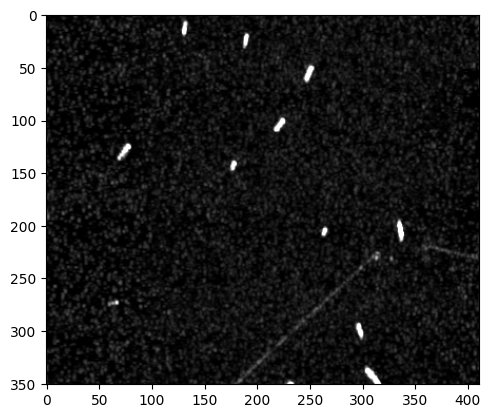

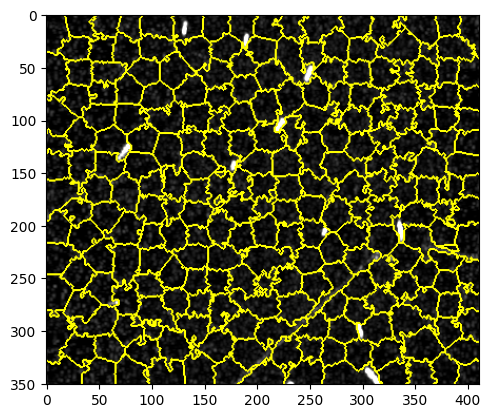

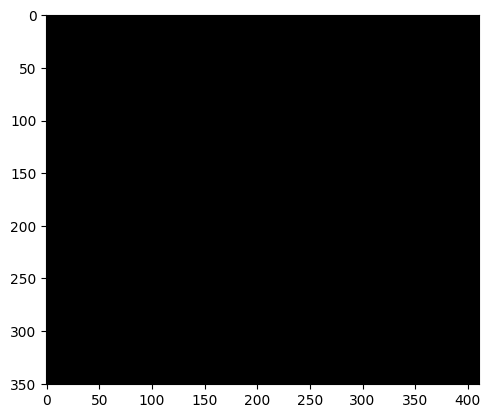

Detected targets: 144261


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, util
from skimage.segmentation import slic, find_boundaries, mark_boundaries
from tkinter import filedialog
from tkinter import Tk
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
import cv2
import networkx as nx
from scipy.special import psi


# Initialisations
back_size = 30  # background band size (RADIAL)
guard_size = 10  # guard band size (RADIAL)
PFA = 0.001  # desired Probability of False Alarm
detections = 0  # initialise detection count
SLIC_k = 300  # SLIC k parameter - number of superpixels
SLIC_m = 10  # SLIC m parameter - compactness

# Read Image
root = Tk()
root.withdraw()
filename = filedialog.askopenfilename()
img = io.imread(filename, as_gray=True)  # Read as a grayscale image
img = img / np.max(img)  # Normalize the image like im2double in MATLAB
plt.figure(), plt.imshow(img, cmap='gray')
img_ext = cv2.copyMakeBorder(img, back_size, back_size, back_size, back_size, cv2.BORDER_REFLECT)  # Extended image
h, l = img.shape
TH = np.zeros((h, l))

# Create 3-channel version for standard SLIC algorithm
fakeRGBimg = color.gray2rgb(img)

# SLIC Segmentation
labels = slic(fakeRGBimg, n_segments=SLIC_k, compactness=SLIC_m, start_label=1)
plt.figure(), plt.imshow(mark_boundaries(img, labels))

# Create RAG using find_boundaries and networkx
boundary_map = find_boundaries(labels, mode='outer')
g = nx.Graph()

# Iterate over the label matrix
for (i, j), label in np.ndenumerate(labels):
    # If node doesn't exist, add it and initialize 'pixels' list
    if not g.has_node(label):
        g.add_node(label, pixels=[])
    
    # Now we are sure the node exists and 'pixels' is initialized, append the pixel position
    g.nodes[label]['pixels'].append((i, j))

    # Connect nodes in RAG if boundary is found
    if boundary_map[i, j]:
        # Check 8-connectivity
        for di in (-1, 0, 1):
            for dj in (-1, 0, 1):
                if di == 0 and dj == 0:
                    continue
                ni, nj = i + di, j + dj
                if ni >= 0 and ni < h and nj >= 0 and nj < l:
                    neighbor_label = labels[ni, nj]
                    if label != neighbor_label and g.has_node(neighbor_label):
                        g.add_edge(label, neighbor_label)

# Split into Superpixel Neighbourhoods
superpixels = {label: [img[x, y] for x, y in g.nodes[label]['pixels']] for label in g.nodes()}
neighbours = {label: [] for label in g.nodes()}

for label, data in g.nodes(data=True):
    for neighbor_label in g.neighbors(label):
        neighbours[label].extend(superpixels[neighbor_label])

# Test throughout Image
maskimg = np.zeros_like(img)  # Initialize maskimg as a matrix of zeros with the same shape as img
for i in range(h):
    for j in range(l):
        cut = img[i, j]
        
        # Get Bands
        current_super = labels[i, j]
        guardband = superpixels[current_super] 
        background = neighbours[current_super]  
     
        # Cauchy-Rayleigh CFAR
        gama = cauchyraylINTgammafit(background, 1) 
        TH[i, j] = np.sqrt((gama ** 2) / (PFA ** 2) - (gama ** 2)) 

        # Check if CUT is target
        if cut >= TH[i, j]:
            maskimg[i, j] = 1
            detections += 1
        else:
            maskimg[i, j] = 0

plt.figure(), plt.imshow(maskimg, cmap='gray')
plt.show()
print(f'Detected targets: {detections}')
